# Data Loading and Preparation

In [2]:
import pandas as pd

file_path = 'Daily Household Transactions.csv'
data = pd.read_csv(file_path)
data.head()

,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR


# Data Preprocessing 

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

missing_values = data.isnull().sum()
print(missing_values)

data['Subcategory'].fillna('Unknown', inplace=True)
data['Note'].fillna('Unknown', inplace=True)

data = data[['Date', 'Mode', 'Category', 'Subcategory', 'Amount', 'Income/Expense']]

data.head()

Date              1303
Mode                 0
Category             0
Subcategory        635
Note               521
Amount               0
Income/Expense       0
Currency             0
dtype: int64


,Date,Mode,Category,Subcategory,Amount,Income/Expense
0,NaT,Cash,Transportation,Train,30.0,Expense
1,NaT,Cash,Food,snacks,60.0,Expense
2,2018-09-19,Saving Bank account 1,subscription,Netflix,199.0,Expense
3,NaT,Saving Bank account 1,subscription,Mobile Service Provider,19.0,Expense
4,NaT,Cash,Festivals,Ganesh Pujan,251.0,Expense


# Exploratory Data Analysis (EDA)

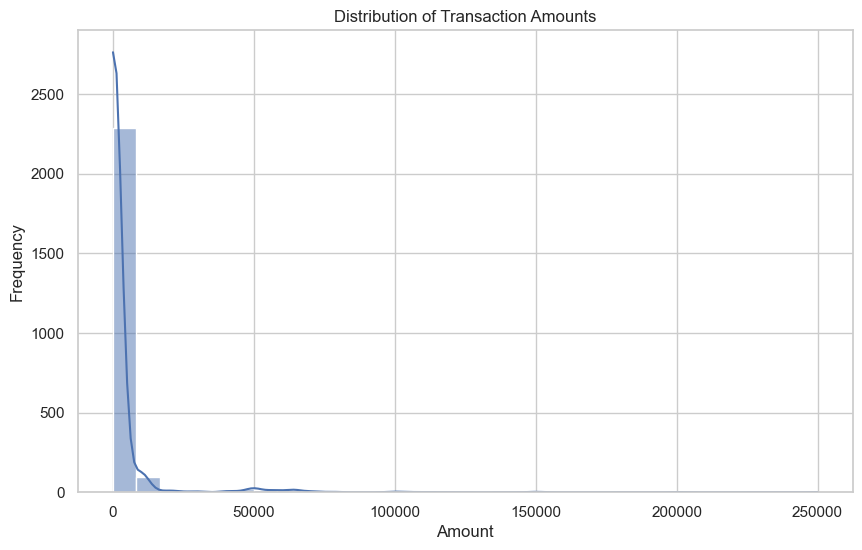

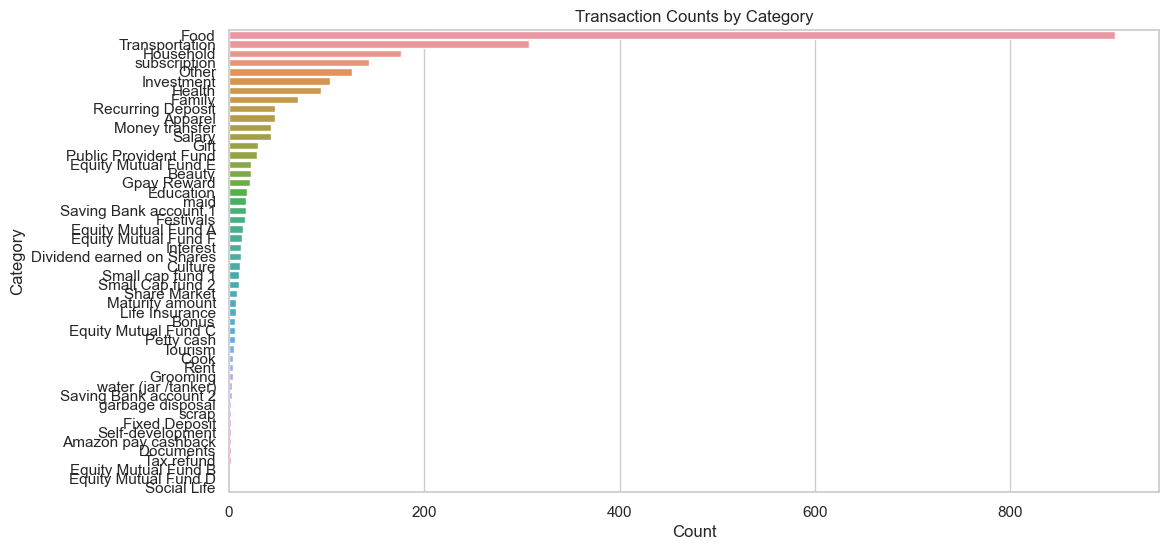

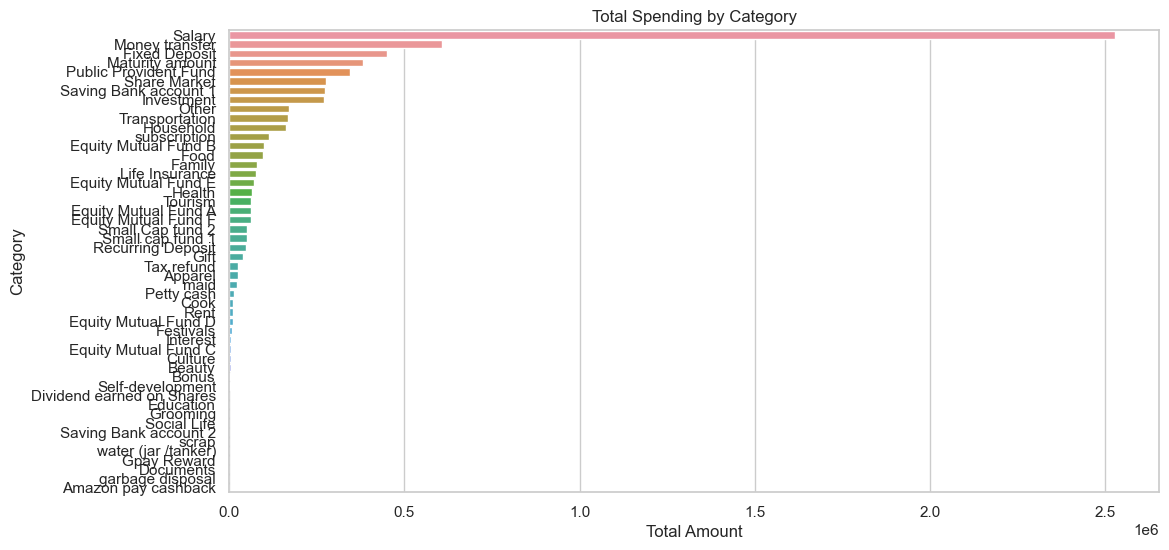

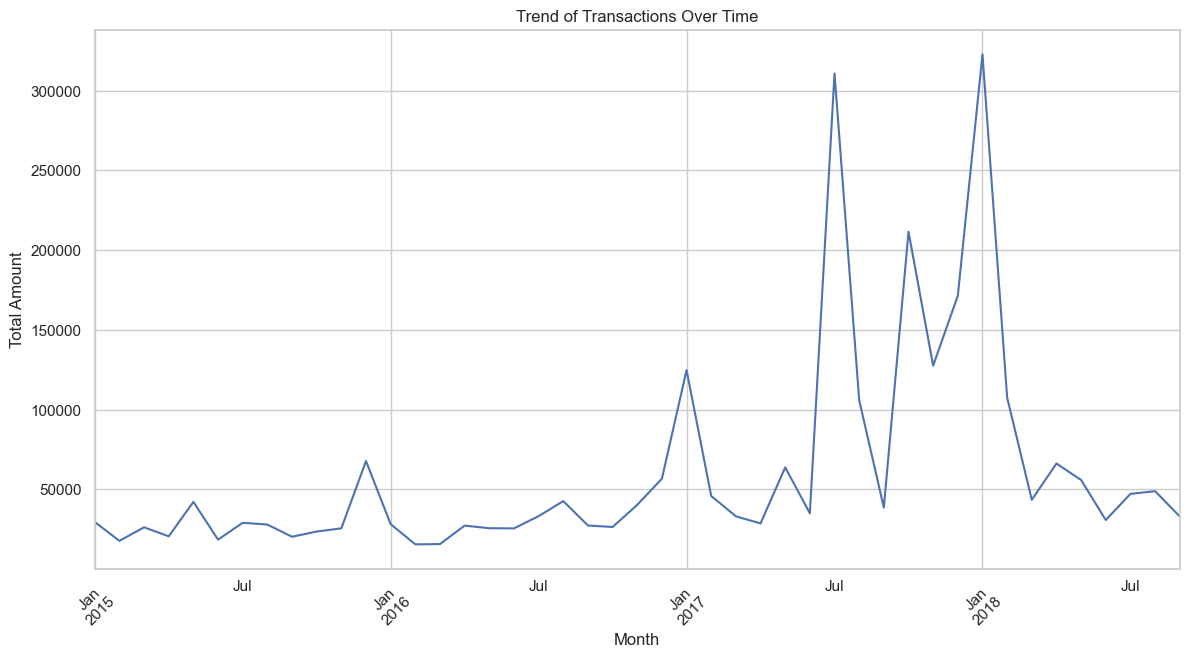

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], kde=True, bins=30)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# 2. Transaction counts by category
plt.figure(figsize=(12, 6))
sns.countplot(y='Category', data=data, order=data['Category'].value_counts().index)
plt.title('Transaction Counts by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# 3. Total spending by category
total_spending_by_category = data.groupby('Category')['Amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=total_spending_by_category.values, y=total_spending_by_category.index)
plt.title('Total Spending by Category')
plt.xlabel('Total Amount')
plt.ylabel('Category')
plt.show()

# 4. Trend of transactions over time
data['Month'] = data['Date'].dt.to_period('M')
monthly_trend = data.groupby('Month')['Amount'].sum()
plt.figure(figsize=(14, 7))
monthly_trend.plot()
plt.title('Trend of Transactions Over Time')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()


# Data Transformation

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding categorical variables
label_encoder = LabelEncoder()
data['Mode'] = label_encoder.fit_transform(data['Mode'])
data['Category'] = label_encoder.fit_transform(data['Category'])
data['Subcategory'] = label_encoder.fit_transform(data['Subcategory'])
data['Income/Expense'] = label_encoder.fit_transform(data['Income/Expense'])

# Normalizing the Amount column
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

# Droping the Month column if it exists
if 'Month' in data.columns:
    data = data.drop(columns=['Month'])
    
data.head()

,Date,Mode,Category,Subcategory,Amount,Income/Expense
0,NaT,0,44,64,-0.217395,0
1,NaT,0,18,88,-0.214998,0
2,2018-09-19,9,48,45,-0.203893,0
3,NaT,9,48,41,-0.218274,0
4,NaT,0,16,20,-0.199739,0


# Clustering

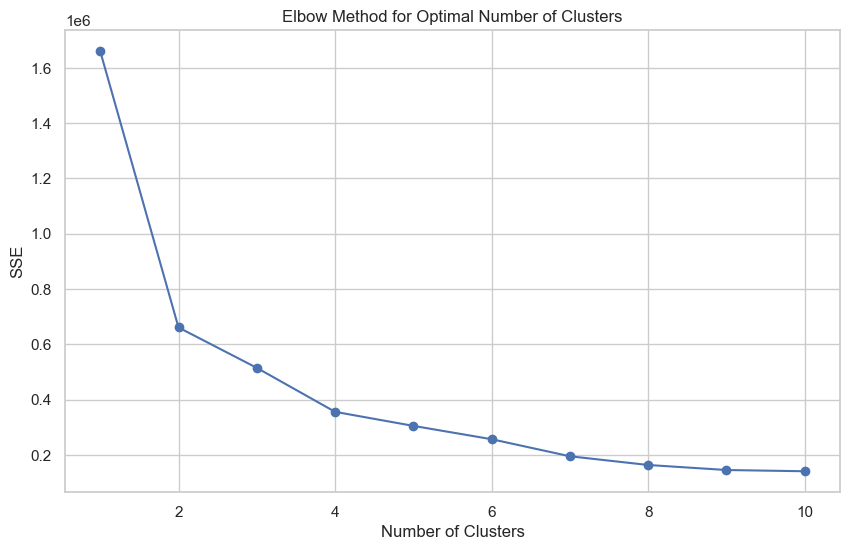

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Preparing the data for clustering 
clustering_data = data.drop(columns=['Date'])

# Determining the optimal number of clusters using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    sse.append(kmeans.inertia_)

# Plot the SSE for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()


# K-means Clustering

In [8]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(clustering_data)

data.head()


,Date,Mode,Category,Subcategory,Amount,Income/Expense,Cluster
0,NaT,0,44,64,-0.217395,0,0
1,NaT,0,18,88,-0.214998,0,3
2,2018-09-19,9,48,45,-0.203893,0,0
3,NaT,9,48,41,-0.218274,0,0
4,NaT,0,16,20,-0.199739,0,1


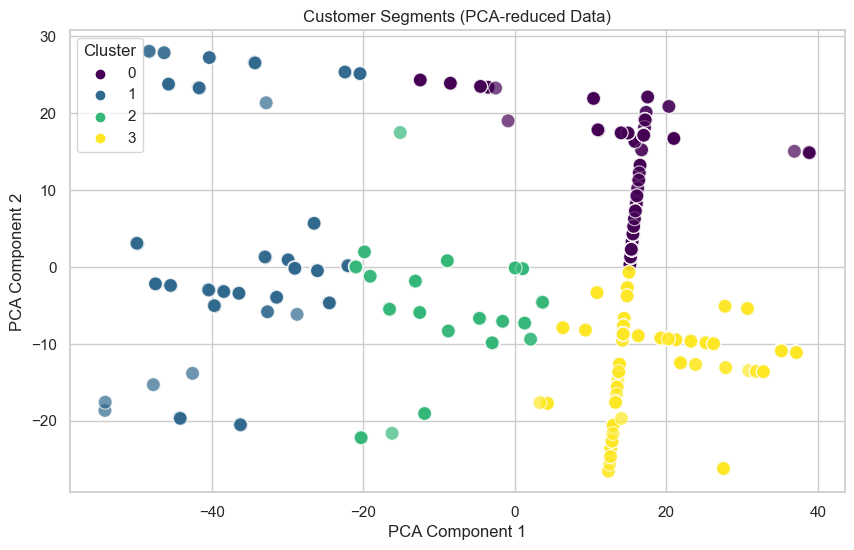

In [9]:
from sklearn.decomposition import PCA

# Reducing dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(clustering_data)

# Creating a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

# Ploting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=pca_df, s=100, alpha=0.7)
plt.title('Customer Segments (PCA-reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
